In [ ]:
!pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k
! mkdir data
! unzip flickr8k.zip -d data

In [ ]:
import torch
import os
import numpy as np
from PIL import Image
import pandas as pd
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, dataset
import torchtext
from torch.nn.functional import one_hot
import torch.optim as optim

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [12, 30]
#plt.rcParams['figure.dpi'] = 100



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [ ]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, length,num,transform=None):
        self.transform = transform
        self.image_dir = os.path.join(dir,"Images")
        self.df = pd.read_csv(os.path.join(dir,"captions.txt"))

        self.length = length

        self.tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
        self.vocab = torchtext.vocab.build_vocab_from_iterator(
            self.tokenizer(caption) for caption in self.df["caption"][0:num]
        )
        self.vocab.append_token("<start>")
        self.vocab.append_token("<end>")
        self.vocab.append_token("<pad>")
        print(self.vocab.get_stoi())

        #Finds incdicies of <start>, <end>, <pad>
        self.special_indices = self.vocab.lookup_indices(["<start>","<end>","<pad>"])
        print(self.special_indices)

        self.df2 = pd.DataFrame(columns=['image','caption','length'])

        for i, (image, caption) in enumerate(zip(self.df['image'],self.df['caption'])):
            if i%1000==0:
                print(i)
            tokens = self.tokenizer(caption)
            tokens[:0] = ["<start>"]
            tokens.append("<end>")
            if len(tokens)>length:
                continue
            length2 = len(tokens)
            while len(tokens)<length:
                tokens.append("<pad>")

            tokens_num = torch.tensor([self.vocab[token] for token in tokens])
            self.df2.loc[-1] = [image,tokens_num,length2]  # adding a row
            self.df2.index = self.df2.index + 1  # shifting index
            self.df2 = self.df2.sort_index()  # sorting by index

            if (i==num-1):
                break



    def __getitem__(self,i):
        caption = self.df2["caption"][i]
        image_path = os.path.join(self.image_dir,self.df2["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,caption)

    def __len__(self):
        return len(self.df2)

In [ ]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
ds = CaptionDataset("/content/data",20,35000,transform=preprocess)
#ds,awd = torch.utils.data.random_split(ds, [int(len(ds)*0.1),len(ds)-int(len(ds)*0.1)])
#vocab_builder = DataLoader(ds,batch_size=1)
#vocab_it = iter(vocab_builder)

#tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
#vocab = torchtext.vocab.build_vocab_from_iterator(
#    tokenizer(caption[1][0]) for caption in vocab_it
#)
dl = DataLoader(ds,batch_size=64,shuffle=True)

{'<pad>': 8376, '<start>': 8374, 'zone': 8372, 'zombies': 8371, 'zip-up': 8367, 'zip-line': 8366, 'zig-zag': 8365, 'zebra': 8363, 'youths': 8359, 'yorkshire': 8355, 'yellowish': 8351, 'yankees': 8348, 'yachts': 8346, 'xmen': 8344, 'wuth': 8343, 'wrinkled': 8338, 'wrestled': 8335, 'wrecks': 8333, 'worships': 8327, 'worm': 8324, 'worked': 8322, 'word': 8321, 'woody': 8316, 'wmoan': 8310, 'witnesses': 8308, 'wispy': 8304, 'wipeout': 8301, 'windsurfers': 8295, 'windshield': 8293, 'windowed': 8291, 'windboarder': 8289, 'windboard': 8288, 'winces': 8286, 'williams': 8283, 'wildebeest': 8282, 'wii': 8280, 'wiener': 8276, 'wields': 8275, 'widows': 8274, 'widow': 8273, 'whoa': 8270, 'whites': 8268, 'white-suited': 8266, 'white-metal': 8265, 'wharfs': 8258, 'wets': 8255, 'werewolf': 8252, 'well-kept': 8250, 'well-groomed': 8249, 'welcome': 8247, 'weiner': 8245, 'weilding': 8243, 'weas': 8239, 'wavy': 8235, 'waterspouts': 8234, 'waterproofs': 8230, 'waterpark': 8229, 'waterhole': 8228, 'waterbed'

In [ ]:
it = iter(dl)

In [ ]:
next(it)

[tensor([[[[-1.8268, -1.7754, -1.8097,  ..., -1.8782, -1.8610, -1.8782],
           [-1.7754, -1.8439, -1.8097,  ..., -1.9295, -1.8610, -1.8610],
           [-1.6898, -1.8439, -1.8953,  ..., -1.8782, -1.8268, -1.8097],
           ...,
           [-1.7412, -1.4843, -1.5357,  ..., -1.2103, -1.1760, -1.3130],
           [-1.5528, -1.4158, -1.3473,  ..., -1.1247, -1.0562, -0.7137],
           [-1.3302, -1.3302, -1.3815,  ..., -1.3644, -1.1075, -0.5596]],
 
          [[-1.8256, -1.7731, -1.8081,  ..., -1.5980, -1.6681, -1.6856],
           [-1.7731, -1.8431, -1.8081,  ..., -1.6331, -1.7031, -1.7031],
           [-1.6681, -1.8431, -1.8782,  ..., -1.6331, -1.6681, -1.6506],
           ...,
           [-0.9678, -0.5826, -0.5651,  ..., -0.0224, -0.1099, -0.4601],
           [-0.6176, -0.5301, -0.4951,  ...,  0.1176,  0.0476,  0.1877],
           [-0.2850, -0.4426, -0.5826,  ..., -0.1099,  0.0301,  0.3803]],
 
          [[-1.6476, -1.6127, -1.6476,  ..., -1.4733, -1.5256, -1.5081],
           [-

In [ ]:
print(ds.df2["caption"])
print(ds.df2["length"])
print(len(ds.vocab))

0        [tensor(8374), tensor(11), tensor(24), tensor(...
1        [tensor(8374), tensor(11), tensor(177), tensor...
2        [tensor(8374), tensor(11), tensor(60), tensor(...
3        [tensor(8374), tensor(0), tensor(24), tensor(4...
4        [tensor(8374), tensor(0), tensor(42), tensor(3...
                               ...                        
33032    [tensor(8374), tensor(0), tensor(39), tensor(1...
33033    [tensor(8374), tensor(0), tensor(39), tensor(1...
33034    [tensor(8374), tensor(0), tensor(39), tensor(1...
33035    [tensor(8374), tensor(0), tensor(17), tensor(3...
33036    [tensor(8374), tensor(0), tensor(42), tensor(2...
Name: caption, Length: 33037, dtype: object
0        13
1        10
2         7
3        12
4        10
         ..
33032    15
33033    12
33034    11
33035    10
33036    20
Name: length, Length: 33037, dtype: int64
8377


In [ ]:
import math
x = [0]*len(ds.vocab)
print(x)
for caption in ds.df2['caption']:
  for i in caption:
    x[i.item()] += 1

print(x)
m = max(x)
weights = []
for i,e in enumerate(x):
  try:
    weights.append(m/(100*e))
  except:
    weights.append(m/100)
print(weights)
weights = torch.tensor(weights)
weights = torch.stack((weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights,weights), dim=0)
print(weights.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from torchsummary import summary

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        #modules = list(resnet.children())[:-2]
        #self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        #self.dem_red1 = nn.Conv2d(2048, 1024, kernel_size=1, padding=0)
        #self.dem_red2 = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        #self.fc1 = nn.Linear(512*7*7,1000)
        #self.act = nn.ReLU()
        #self.fc2 = nn.Linear(1000,100)

    def forward(self,x):
        x = self.resnet(x)
        #x = self.act(x)
        #x = self.dem_red1(x)
        #x = self.act(x)
        #x = self.dem_red2(x)
        #x = self.act(x)
        #x = torch.flatten(x,start_dim=1)
        #x = self.fc1(x)
        #x = self.act(x)
        #x = self.fc2(x)
        return x

model = Encoder()

summary(model.to(device), (3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 156MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Decoder(nn.Module):
    #LSTM
    def __init__(self, embedding_dim, encoded_dim, vocab_size, output_length):
        super().__init__()
        self.hidden_dim = encoded_dim
        self.vocab_size = vocab_size
        self.output_length = output_length

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim, encoded_dim)
        self.linear = nn.Linear(encoded_dim, vocab_size)

        self.drop = nn.Dropout(0.2)

        self.positional_emb = nn.Embedding(encoded_dim, embedding_dim)

    def forward(self, start_word, h0, label):
        word = self.embeddings(start_word)
        hx = h0
        cx = h0
        outputs = torch.clone(one_hot(start_word,self.vocab_size))
        word = torch.squeeze(word,1)
        while outputs.size(1)<self.output_length:
            word = self.embeddings(label[outputs.size(1)])
            word = self.drop(word + h0)
            hx, cx = self.lstm(word, (hx, cx))
            word = self.linear(self.drop(hx))
            outputs = torch.cat((outputs,torch.unsqueeze(word,dim=1)),dim=1)
            word = self.embeddings(torch.argmax(word,dim=1))
        return outputs

#d = Decoder(10,10,15)
#start = (torch.unsqueeze(torch.ones(13),1)*14).to(torch.int64)
#print(start)
#print(start.shape)
#enc = torch.rand(13,10)
#print(enc)
#print(enc.shape)
#o = d(start,enc)
#print(o)
#print(o.shape)
#lab = torch.randint(0,15,(13,3))
#lab = one_hot(lab).to(torch.float)
#print(lab.shape)
#criterion = nn.CrossEntropyLoss()
#loss = criterion(o,lab)
#print(loss)
#loss.backward()

In [ ]:
def train(encoder, decoder, optimizer, criterion, loader, epochs, start_token_idx):
    summ = [0,0,0,0,0,0,0,0,0,0,0,0]
    for epoch in range(epochs):
        print("Processing Epoch:",epoch)
        for batch_nr, (image, label) in enumerate(loader):
            print("Starting batch:", batch_nr)
            image = image.to(device)
            label = label.to(device)

            # Forward pass
            img = encoder(image)

            start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*start_token_idx).to(torch.int64).to(device)

            pred = decoder(start_tokens, img, label)
            label = one_hot(label).to(torch.float)

            #Backwards pass
            optimizer.zero_grad()
            #pred = pred.flatten(1,2)
            #label = label.flatten(1,2)
            loss = criterion(pred,label)
            print(loss.item()*1000)
            summ.append(loss.item())
            print("Running avg:", sum(summ[-10:])*100)
            loss.backward()
            optimizer.step()

            if batch_nr%50==0:
              try:
                img, label = next(it)
              except:
                it = iter(loader)
                img, label = next(it)

              plt.imshow(img[0].permute(1, 2, 0))
              plt.show()
              img = encoder(img.to(device))
              start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*ds.special_indices[0]).to(torch.int64).to(device)
              pred = torch.argmax(decoder(start_tokens, img),dim=2)
              print(pred.shape)
              print(label.shape)
              print(ds.vocab.lookup_tokens(label[0].tolist()))
              print(ds.vocab.lookup_tokens(pred[0].tolist()))


Processing Epoch: 0
Starting batch: 0
7.059207186102867
Running avg: 0.7059207186102867


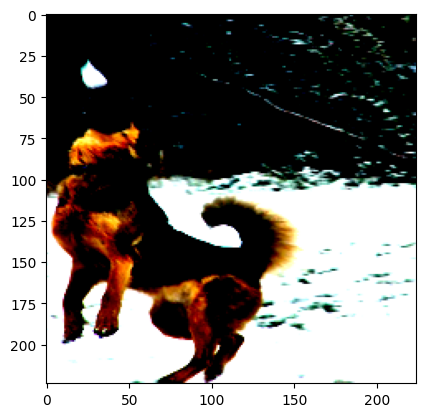

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'a', 'dog', 'trying', 'to', 'catch', 'a', 'snowball', 'in', 'the', 'snow', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'patiently', 'monster', 'pretends', 'david', 'black-clad', 'bat', 'bouncing', 'furniture', 'golfers', 'bow-tie', 'bow-tie', 'bright-colored', 'sideline', 'overshirt', 'faux', 'patiently', 'pull', 'furniture', 'bungee-jumping']
Starting batch: 1
7.014763075858355
Running avg: 1.4073970261961222
Starting batch: 2
6.978175602853298
Running avg: 2.105214586481452
Starting batch: 3
6.924044340848923
Running avg: 2.7976190205663443
Starting batch: 4
6.871925201267004
Running avg: 3.4848115406930447
Starting batch: 5
6.874960381537676
Running avg: 4.172307578846812
Starting batch: 6
6.840766873210669
Running avg: 4.856384266167879
Starting batch: 7
6.79673021659255
Running avg: 5.536057287827134
Starting batch: 8
6.74783531576395
Running avg: 6.210840819403529
Starting batch: 9


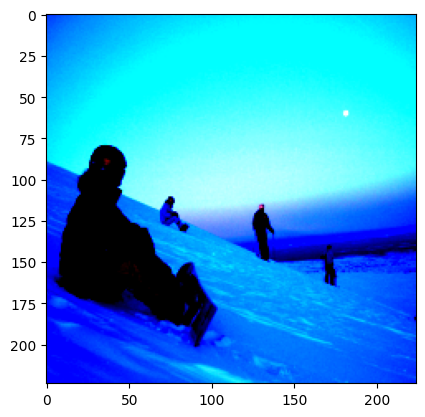

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'a', 'snowboarder', 'takes', 'a', 'rest', 'on', 'the', 'mountainside', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'rummaging', 'steered', 'steered', 'company', 'scattered', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 51
5.929308012127876
Running avg: 5.966984014958143
Starting batch: 52
5.879469215869904
Running avg: 5.950040929019451
Starting batch: 53
5.913189146667719
Running avg: 5.940955504775047
Starting batch: 54
5.9116315096616745
Running avg: 5.935664149001241
Starting batch: 55
5.8960821479558945
Running avg: 5.931140715256333
Starting batch: 56
5.8738659135997295
Running avg: 5.919155897572637
Starting batch: 57
5.890423431992531
Running avg: 5.913548404350877
Starting batch: 58
5.883402191102505
Running avg: 5.907685682177544
Starting batch: 59
5.978410132229328
Running a

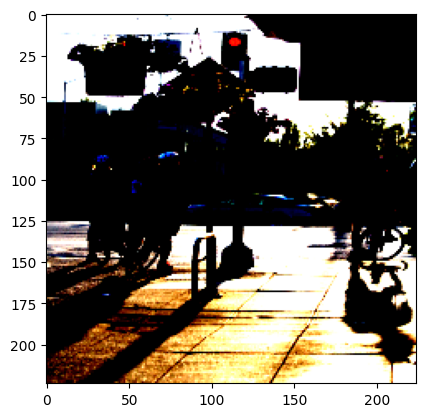

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'people', 'waiting', 'at', 'a', 'light', 'on', 'bikes', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'man', 'in', 'a', 'on', '.', '.', '.', '.', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 101
5.670425016433001
Running avg: 5.6936700362712145
Starting batch: 102
5.636345595121384
Running avg: 5.690751876682043
Starting batch: 103
5.633351858705282
Running avg: 5.68065051920712
Starting batch: 104
5.621404852718115
Running avg: 5.6733333971351385
Starting batch: 105
5.67993987351656
Running avg: 5.677868518978357
Starting batch: 106
5.555589683353901
Running avg: 5.6572106666862965
Starting batch: 107
5.679871421307325
Running avg: 5.6573189329355955
Starting batch: 108
5.645696073770523
Running avg: 5.658316984772682
Starting batch: 109
5.603322759270668
Running avg: 5.643578618764877
Starting batch: 11

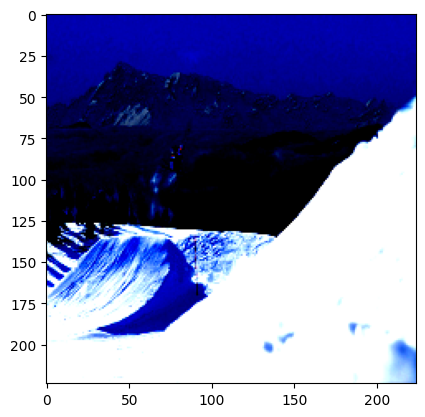

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'a', 'snowboarder', 'takes', 'a', 'ramp', 'made', 'of', 'snow', 'while', 'others', 'watch', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'is', 'is', 'a', 'is', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 151
5.573122762143612
Running avg: 5.513266380876303
Starting batch: 152
5.570049863308668
Running avg: 5.523499986156821
Starting batch: 153
5.459839943796396
Running avg: 5.516615649685264
Starting batch: 154
5.541467107832432
Running avg: 5.52408630028367
Starting batch: 155
5.540870130062103
Running avg: 5.52511615678668
Starting batch: 156
5.529121495783329
Running avg: 5.530200619250536
Starting batch: 157
5.6011732667684555
Running avg: 5.536595126613975
Starting batch: 158
5.478701088577509
Running avg: 5.54007887840271
Starting batch: 159
5.450133699923754
Running avg: 5.527191609144211
Startin

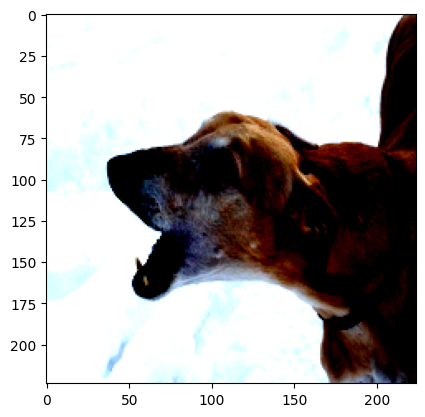

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'a', 'brown', 'dog', 'barks', 'surrounded', 'by', 'white', 'snow', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dogs', 'is', 'is', 'in', '.', '.', '.', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 201
5.422936752438545
Running avg: 5.412427522242069
Starting batch: 202
5.389314144849777
Running avg: 5.409241048619151
Starting batch: 203
5.466912407428026
Running avg: 5.412727780640125
Starting batch: 204
5.477136932313442
Running avg: 5.42470128275454
Starting batch: 205
5.6079355999827385
Running avg: 5.4600371979177
Starting batch: 206
5.423126742243767
Running avg: 5.459701828658581
Starting batch: 207
5.5380393750965595
Running avg: 5.463185952976346
Starting batch: 208
5.35112340003252
Running avg: 5.463047791272402
Starting batch: 209
5.386166274547577
Running avg: 5.455624265596271
Starting bat

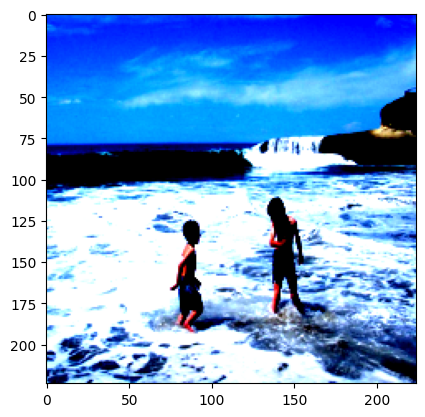

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'two', 'boys', 'play', 'in', 'the', 'ocean', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'man', 'is', 'is', 'in', 'in', '.', '.', '.', '.', '.', '.', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 251
5.385603290051222
Running avg: 5.371375055983663
Starting batch: 252
5.346027202904224
Running avg: 5.370237585157156
Starting batch: 253
5.363961216062307
Running avg: 5.363885127007961
Starting batch: 254
5.3343274630606174
Running avg: 5.366136878728867
Starting batch: 255
5.408988334238529
Running avg: 5.369151011109352
Starting batch: 256
5.242439918220043
Running avg: 5.351740168407559
Starting batch: 257
5.268281791359186
Running avg: 5.350948544219136
Starting batch: 258
5.349970422685146
Running avg: 5.341431498527527
Starting batch: 259
5.310902837663889
Running avg: 5.343807488679886
Starting batch: 260
5.4124384

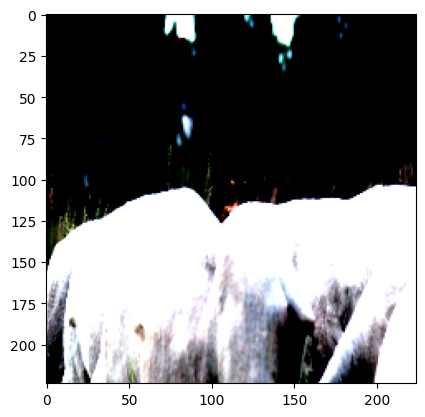

torch.Size([64, 20])
torch.Size([64, 20])
['<start>', 'a', 'black', 'and', 'brown', 'dog', 'pokes', 'his', 'head', 'above', 'the', 'white', 'farm', 'animals', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'dogs', 'is', 'is', 'is', '.', '.', '.', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Starting batch: 301
5.369217600673437
Running avg: 5.298923887312412
Starting batch: 302
5.327831953763962
Running avg: 5.300605436787009
Starting batch: 303
5.296165589243174
Running avg: 5.2996395621448755
Starting batch: 304
5.41692366823554
Running avg: 5.314016807824373
Starting batch: 305
5.26453647762537
Running avg: 5.31430677510798
Starting batch: 306
5.300207994878292
Running avg: 5.300652794539928
Starting batch: 307
5.377804860472679
Running avg: 5.311110196635127
Starting batch: 308
5.252525210380554
Running avg: 5.307159898802638
Starting batch: 309
5.226263776421547
Running avg: 5.308270268142223
Starting batch: 310

In [ ]:
LEARNING_RATE = 0.0001
EPOCHS = 100

encoder = Encoder().to(device)
decoder = Decoder(1000,1000,len(ds.vocab),20).to(device)
#weight=torch.tensor(weigths) weight=torch.tensor(weights.flatten())
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

train(encoder,decoder,optimizer,criterion,dl,EPOCHS,ds.special_indices[0])


In [ ]:
img, label = next(it)
plt.imshow(img[0].permute(1, 2, 0))
img = encoder(img.to(device))
start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*ds.special_indices[0]).to(torch.int64).to(device)
pred = torch.argmax(decoder(start_tokens, img),dim=2)
print(pred.shape)
print(label.shape)
print(ds.vocab.lookup_tokens(label[0].tolist()))
print(ds.vocab.lookup_tokens(pred[0].tolist()))